In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

print("Environment configured")

Environment configured


# YOLOv8 Facial Expression Recognition (FER) - Google Colab Training

Train a **YOLOv8-cls FER classifier** using **Balanced AffectNet + Custom Dataset**.

### **Dataset Sources**

**Balanced AffectNet:**
- Download from: https://www.kaggle.com/datasets/dollyprajapati182/balanced-affectnet

**Custom Dataset:**
```
fer-custom-dataset/
├── angry/     (207 images, 224x224 RGB)
├── happy/     (200 images, 224x224 RGB)
├── neutral/   (245 images, 224x224 RGB)
├── sad/       (170 images, 224x224 RGB)
└── surprised/ (201 images, 224x224 RGB)
```

## 1. Mount Google Drive

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("Google Drive mounted successfully")

Mounted at /content/drive
Google Drive mounted successfully


## 2. Check GPU Availability

In [3]:
# Check GPU availability
import torch

print("GPU CHECK")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print("\nGPU is ready for training!")
else:
    print("\nNo GPU found - training will be slower")

GPU CHECK
PyTorch Version: 2.9.0+cu126
CUDA Available: True
GPU Device: Tesla T4
GPU Memory: 15.8 GB

GPU is ready for training!


## 3. Import Required Libraries

In [4]:
# Install ultralytics (YOLOv8)
!pip install ultralytics -q

# Import libraries
import os
import shutil
import numpy as np
from pathlib import Path

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from PIL import Image

# YOLOv8
from ultralytics import YOLO

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.7 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
All libraries imported successfully


# 4. Kaggle API

In [5]:
# Install Kaggle API
!pip install -q kaggle

# Upload your kaggle.json file
from google.colab import files
import os
import json

print("KAGGLE API SETUP")

kaggle_dir = os.path.expanduser('~/.kaggle')
kaggle_json_path = os.path.join(kaggle_dir, 'kaggle.json')

# Path to kaggle.json in Google Drive
drive_kaggle_json = '/content/drive/MyDrive/AUPP/ICT_361_Robotics/Final_Project/kaggle.json'

if os.path.exists(kaggle_json_path):
    print("Kaggle API credentials already configured")
elif os.path.exists(drive_kaggle_json):
    print(f"Found kaggle.json in Google Drive: {drive_kaggle_json}")
    os.makedirs(kaggle_dir, exist_ok=True)
    shutil.copy2(drive_kaggle_json, kaggle_json_path)
    os.chmod(kaggle_json_path, 0o600)
    print(f"Kaggle credentials configured from Google Drive")

KAGGLE API SETUP
Found kaggle.json in Google Drive: /content/drive/MyDrive/AUPP/ICT_361_Robotics/Final_Project/kaggle.json
Kaggle credentials configured from Google Drive


# 5. Download AffectNet Dataset

In [6]:
# Download Balanced AffectNet dataset from Kaggle
print("DOWNLOADING BALANCED AFFECTNET FROM KAGGLE")

# Create directory for dataset
dataset_dir = '/content/datasets'
os.makedirs(dataset_dir, exist_ok=True)

# Download the dataset
print("\nDownloading dataset...")
print("   Dataset: dollyprajapati182/balanced-affectnet")

!kaggle datasets download -d dollyprajapati182/balanced-affectnet -p {dataset_dir} --unzip

print("\nDownload complete!")

# Verify download
affectnet_path = os.path.join(dataset_dir, 'balanced-affectnet')
if os.path.exists(affectnet_path):
    print(f"Dataset extracted to: {affectnet_path}")

    # List contents
    print("\nDataset structure:")
    for split in ['train', 'val', 'test']:
        split_path = os.path.join(affectnet_path, split)
        if os.path.exists(split_path):
            folders = os.listdir(split_path)
            print(f"  {split}/: {folders}")
else:
    # Check if files are in dataset_dir directly
    print(f"\nDataset might be in: {dataset_dir}")
    print("Contents:")
    for item in os.listdir(dataset_dir)[:10]:
        print(f"  • {item}")

DOWNLOADING BALANCED AFFECTNET FROM KAGGLE

   Dataset: dollyprajapati182/balanced-affectnet
Dataset URL: https://www.kaggle.com/datasets/dollyprajapati182/balanced-affectnet
License(s): unknown
 87% 238M/273M [00:00<00:00, 558MB/s]
100% 273M/273M [00:00<00:00, 582MB/s]

Download complete!

Dataset might be in: /content/datasets
Contents:
  • test
  • train
  • val


## 6. Configuration & Dataset Path

In [7]:
# ============== CONFIGURATION ==============
IMG_SIZE = 128          # YOLOv8 input size (resize from 75x75)
BATCH_SIZE = 16         # Batch size for training
EPOCHS = 50             # Number of epochs (with early stopping)
LEARNING_RATE = 0.001   # Learning rate
NUM_CLASSES = 5         # 5 emotion classes
MAX_AFFECTNET_PER_CLASS = 3000

# Target emotion classes for robot control
CLASS_NAMES = ['angry', 'happy', 'neutral', 'sad', 'surprised']

# Balanced AffectNet folder mapping
AFFECTNET_MAPPING = {
    'anger': 'angry',
    'happy': 'happy',
    'neutral': 'neutral',
    'sad': 'sad',
    'surprise': 'surprised',
    'contempt': None,
    'disgust': None,
    'fear': None,
}

# ============== DATASET PATHS ==============
# Balanced AffectNet
AFFECTNET_DIR = '/content/datasets'

# Custom dataset
CUSTOM_DATA_DIR = '/content/drive/MyDrive/AUPP/ICT_361_Robotics/Final_Project/custom_emotions'

# Set to True to use custom dataset
USE_CUSTOM_DATA = True

# Output directory (Colab working directory)
OUTPUT_DIR = '/content/output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("CONFIGURATION - YOLOv8 CLASSIFICATION")
print(f"Model: YOLOv8n-cls (nano classifier)")
print(f"Image Size: {IMG_SIZE}×{IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Classes: {CLASS_NAMES}")
print(f"\nDATASETS:")
print(f"  • AffectNet: {AFFECTNET_DIR}")
print(f"  • Custom: {CUSTOM_DATA_DIR if USE_CUSTOM_DATA else 'Not used'}")

CONFIGURATION - YOLOv8 CLASSIFICATION
Model: YOLOv8n-cls (nano classifier)
Image Size: 128×128
Batch Size: 16
Epochs: 50
Classes: ['angry', 'happy', 'neutral', 'sad', 'surprised']

DATASETS:
  • AffectNet: /content/datasets
  • Custom: /content/drive/MyDrive/AUPP/ICT_361_Robotics/Final_Project/custom_emotions


## 7. Load and Check Datasets

In [8]:
# Check all datasets
print("CHECKING DATASETS")

# Check AffectNet dataset
print("-" * 40)
print("BALANCED AFFECTNET:")
print("-" * 40)

affectnet_stats = {'train': {}, 'val': {}, 'test': {}}

if os.path.exists(AFFECTNET_DIR):
    print(f"Found at: {AFFECTNET_DIR}")
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(AFFECTNET_DIR, split)
        if os.path.exists(split_dir):
            for folder in os.listdir(split_dir):
                folder_path = os.path.join(split_dir, folder)
                if os.path.isdir(folder_path):
                    target_class = AFFECTNET_MAPPING.get(folder.lower())
                    if target_class:
                        count = len([f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
                        affectnet_stats[split][target_class] = count

    for split in ['train', 'val', 'test']:
        total = sum(affectnet_stats[split].values())
        print(f"   {split}: {total} images")
else:
    print(f"NOT FOUND at: {AFFECTNET_DIR}")
    print("   → Make sure the download cell completed successfully")
    print("   → Check if dataset is at /content/datasets/")
    if os.path.exists('/content/datasets'):
        print("   → Contents of /content/datasets/:")
        for item in os.listdir('/content/datasets')[:10]:
            print(f"      • {item}")

# Check Custom dataset
print("\n" + "-" * 40)
print("CUSTOM DATASET:")
print("-" * 40)

custom_stats = {}

if USE_CUSTOM_DATA and CUSTOM_DATA_DIR:
    if os.path.exists(CUSTOM_DATA_DIR):
        print(f"Found at: {CUSTOM_DATA_DIR}")

        # Check structure - might be flat or have train/val/test
        has_splits = os.path.exists(os.path.join(CUSTOM_DATA_DIR, 'train'))

        if has_splits:
            print("   Structure: train/val/test folders")
            for split in ['train', 'val', 'test']:
                split_dir = os.path.join(CUSTOM_DATA_DIR, split)
                if os.path.exists(split_dir):
                    for class_name in CLASS_NAMES:
                        class_dir = os.path.join(split_dir, class_name)
                        if os.path.exists(class_dir):
                            count = len([f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
                            custom_stats[f"{split}_{class_name}"] = count
                            print(f"   {split}/{class_name}: {count} images")
        else:
            print("   Structure: flat (class folders only)")
            for class_name in CLASS_NAMES:
                class_dir = os.path.join(CUSTOM_DATA_DIR, class_name)
                if os.path.exists(class_dir):
                    count = len([f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
                    custom_stats[class_name] = count
                    print(f"   {class_name}: {count} images")
                else:
                    print(f"   {class_name}: not found")

        total_custom = sum(custom_stats.values())
        print(f"\n   Total custom images: {total_custom}")
    else:
        print(f"NOT FOUND at: {CUSTOM_DATA_DIR}")
        print("   → Upload your custom dataset to Google Drive")
        print("   → Or set USE_CUSTOM_DATA = False to skip")
else:
    print("   Skipped (USE_CUSTOM_DATA = False)")

CHECKING DATASETS
----------------------------------------
BALANCED AFFECTNET:
----------------------------------------
Found at: /content/datasets
   train: 17627 images
   val: 4556 images
   test: 2546 images

----------------------------------------
CUSTOM DATASET:
----------------------------------------
Found at: /content/drive/MyDrive/AUPP/ICT_361_Robotics/Final_Project/custom_emotions
   Structure: flat (class folders only)
   angry: 207 images
   happy: 200 images
   neutral: 245 images
   sad: 169 images
   surprised: 200 images

   Total custom images: 1021


### 8. Visualize Sample Images

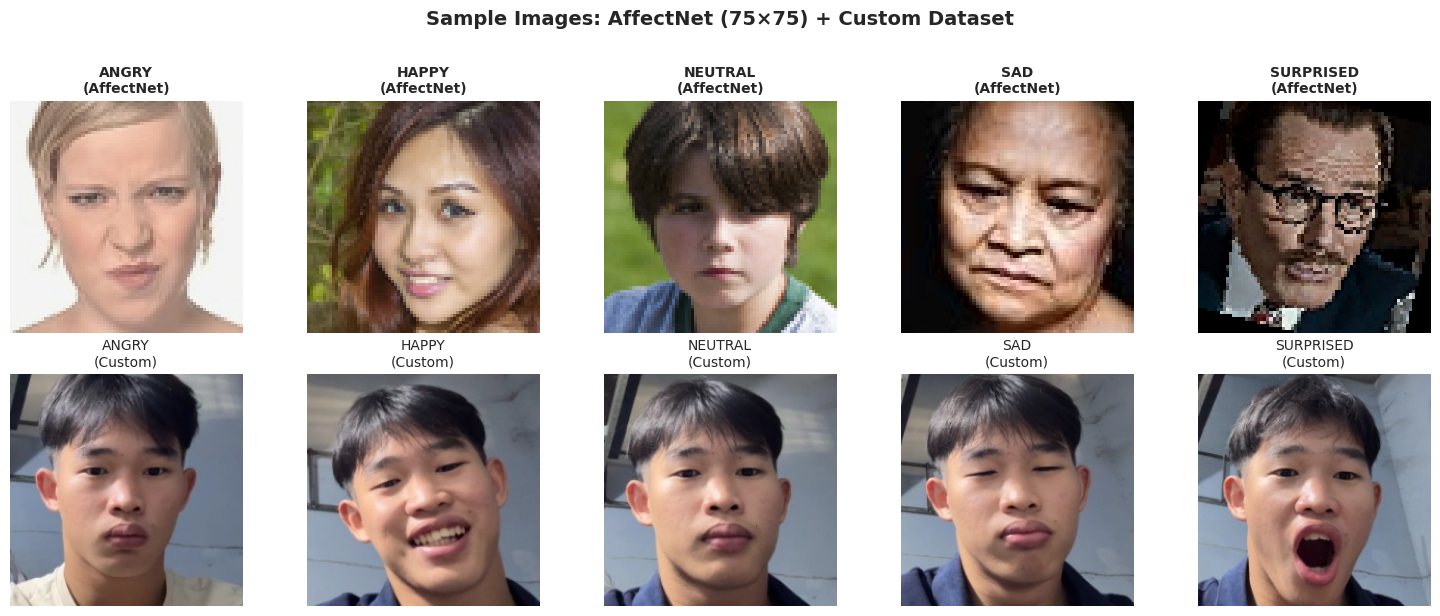

In [9]:
# Display sample images from both datasets
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Map AffectNet folder names to our class names
FOLDER_TO_CLASS = {
    'Anger': 'angry',
    'Happy': 'happy',
    'Neutral': 'neutral',
    'Sad': 'sad',
    'Surprise': 'surprised'
}

train_dir = os.path.join(AFFECTNET_DIR, 'train')

for idx, (folder_name, class_name) in enumerate(FOLDER_TO_CLASS.items()):
    class_path = os.path.join(train_dir, folder_name)

    if os.path.exists(class_path):
        img_files = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

        if len(img_files) >= 2:
            # First sample (AffectNet)
            img_path = os.path.join(class_path, img_files[0])
            img = Image.open(img_path)
            axes[0, idx].imshow(img)
            axes[0, idx].set_title(f'{class_name.upper()}\n(AffectNet)', fontsize=10, fontweight='bold')
            axes[0, idx].axis('off')

            # Second sample - try custom dataset
            custom_class_dir = os.path.join(CUSTOM_DATA_DIR, class_name) if USE_CUSTOM_DATA else None
            if custom_class_dir and os.path.exists(custom_class_dir):
                custom_files = [f for f in os.listdir(custom_class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
                if custom_files:
                    img_path2 = os.path.join(custom_class_dir, custom_files[0])
                    img2 = Image.open(img_path2)
                    axes[1, idx].imshow(img2)
                    axes[1, idx].set_title(f'{class_name.upper()}\n(Custom)', fontsize=10)
                    axes[1, idx].axis('off')
                else:
                    axes[1, idx].text(0.5, 0.5, 'No custom\nimages', ha='center', va='center')
                    axes[1, idx].axis('off')
            else:
                img_path2 = os.path.join(class_path, img_files[1])
                img2 = Image.open(img_path2)
                axes[1, idx].imshow(img2)
                axes[1, idx].set_title(f'{class_name.upper()}\n(AffectNet 2)', fontsize=10)
                axes[1, idx].axis('off')
    else:
        axes[0, idx].text(0.5, 0.5, f'{folder_name}\nNot Found', ha='center', va='center')
        axes[0, idx].axis('off')
        axes[1, idx].axis('off')

plt.suptitle('Sample Images: AffectNet (75×75) + Custom Dataset', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 9. Data Preprocessing & Augmentation

In [10]:
# Prepare MERGED dataset for YOLOv8 (AffectNet + Custom)
print("PREPARING MERGED DATASET FOR YOLOV8")

# Map AffectNet folder names to our classes
FOLDER_MAPPING = {
    'Anger': 'angry', 'anger': 'angry',
    'Happy': 'happy', 'happy': 'happy',
    'Neutral': 'neutral', 'neutral': 'neutral',
    'Sad': 'sad', 'sad': 'sad',
    'Surprise': 'surprised', 'surprise': 'surprised', 'surprised': 'surprised',
}

# Create YOLOv8 dataset directory
yolo_dataset_dir = os.path.join(OUTPUT_DIR, 'yolo_fer_dataset')
yolo_train_dir = os.path.join(yolo_dataset_dir, 'train')
yolo_val_dir = os.path.join(yolo_dataset_dir, 'val')
yolo_test_dir = os.path.join(yolo_dataset_dir, 'test')

# Create directories
for class_name in CLASS_NAMES:
    os.makedirs(os.path.join(yolo_train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(yolo_val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(yolo_test_dir, class_name), exist_ok=True)

stats = {'affectnet': {'train': {}, 'val': {}, 'test': {}},
         'custom': {'train': {}, 'val': {}, 'test': {}}}

# ============== PROCESS AFFECTNET (CORRECTLY LIMITED) ==============
print("\nProcessing AffectNet dataset (CORRECTLY LIMITED)...")
print(f"   Limiting to {MAX_AFFECTNET_PER_CLASS} images TOTAL per class (not per split)")
print(f"   Split ratio: 70% train, 20% val, 10% test")

import random
random.seed(42)  # For reproducibility

# Process each class separately to ensure proper limiting
for class_name in CLASS_NAMES:
    # Collect ALL images for this class across all splits
    all_class_images = []

    for split in ['train', 'val', 'test']:
        src_split_dir = os.path.join(AFFECTNET_DIR, split)
        if not os.path.exists(src_split_dir):
            continue

        for folder_name in os.listdir(src_split_dir):
            folder_path = os.path.join(src_split_dir, folder_name)
            if not os.path.isdir(folder_path):
                continue

            target_class = FOLDER_MAPPING.get(folder_name)
            if target_class != class_name:
                continue

            # Get all images from this folder
            img_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)
                        if f.endswith(('.png', '.jpg', '.jpeg'))]
            all_class_images.extend(img_files)

    # LIMIT TOTAL images per class
    if len(all_class_images) > MAX_AFFECTNET_PER_CLASS:
        all_class_images = random.sample(all_class_images, MAX_AFFECTNET_PER_CLASS)

    # Shuffle and split 70/20/10
    random.shuffle(all_class_images)
    n_total = len(all_class_images)
    n_train = int(n_total * 0.70)
    n_val = int(n_total * 0.20)

    split_images = {
        'train': all_class_images[:n_train],
        'val': all_class_images[n_train:n_train+n_val],
        'test': all_class_images[n_train+n_val:]
    }

    # Copy images to destination
    for split, img_paths in split_images.items():
        if split == 'train':
            dst_dir = os.path.join(yolo_train_dir, class_name)
        elif split == 'val':
            dst_dir = os.path.join(yolo_val_dir, class_name)
        else:
            dst_dir = os.path.join(yolo_test_dir, class_name)

        count = 0
        for src_path in img_paths:
            dst_path = os.path.join(dst_dir, f"affectnet_{class_name}_{split}_{count:05d}.jpg")

            try:
                img = cv2.imread(src_path)
                if img is None:
                    continue
                img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)
                cv2.imwrite(dst_path, img_resized)
                count += 1
            except:
                continue

        stats['affectnet'][split][class_name] = count

# Print split totals
for split in ['train', 'val', 'test']:
    total = sum(stats['affectnet'][split].values())
    print(f"  ✓ {split}: {total} images")

# ============== PROCESS CUSTOM DATASET (ALL IMAGES) ==============
if USE_CUSTOM_DATA and os.path.exists(CUSTOM_DATA_DIR):
    print("\nProcessing Custom dataset (ALL IMAGES - PRIORITY)...")

    # Check if custom has train/val/test or flat structure
    has_splits = os.path.exists(os.path.join(CUSTOM_DATA_DIR, 'train'))

    if has_splits:
        # Custom dataset has train/val/test structure
        for split in ['train', 'val', 'test']:
            split_dir = os.path.join(CUSTOM_DATA_DIR, split)
            if not os.path.exists(split_dir):
                continue

            for class_name in CLASS_NAMES:
                class_dir = os.path.join(split_dir, class_name)
                if not os.path.exists(class_dir):
                    continue

                if split == 'train':
                    dst_dir = os.path.join(yolo_train_dir, class_name)
                elif split == 'val':
                    dst_dir = os.path.join(yolo_val_dir, class_name)
                else:
                    dst_dir = os.path.join(yolo_test_dir, class_name)

                # USE ALL CUSTOM IMAGES
                img_files = [f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
                count = 0

                for img_file in img_files:
                    src_path = os.path.join(class_dir, img_file)
                    dst_path = os.path.join(dst_dir, f"custom_{class_name}_{split}_{count:05d}.jpg")

                    try:
                        img = cv2.imread(src_path)
                        if img is None:
                            continue
                        # Resize if needed
                        if img.shape[0] != IMG_SIZE or img.shape[1] != IMG_SIZE:
                            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)
                        cv2.imwrite(dst_path, img)
                        count += 1
                    except:
                        continue

                stats['custom'][split][class_name] = count

            total = sum(stats['custom'][split].values())
            print(f"  {split}: {total} images (ALL custom images included)")
    else:
        # Flat structure - split 70/15/15 for train/val/test
        print("  (Flat structure detected - splitting 70/15/15)")

        for class_name in CLASS_NAMES:
            class_dir = os.path.join(CUSTOM_DATA_DIR, class_name)
            if not os.path.exists(class_dir):
                continue

            # USE ALL CUSTOM IMAGES
            img_files = [f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

            # Shuffle and split
            random.shuffle(img_files)

            n_total = len(img_files)
            n_train = int(n_total * 0.70)
            n_val = int(n_total * 0.15)

            splits_files = {
                'train': img_files[:n_train],
                'val': img_files[n_train:n_train+n_val],
                'test': img_files[n_train+n_val:]
            }

            for split, files in splits_files.items():
                if split == 'train':
                    dst_dir = os.path.join(yolo_train_dir, class_name)
                elif split == 'val':
                    dst_dir = os.path.join(yolo_val_dir, class_name)
                else:
                    dst_dir = os.path.join(yolo_test_dir, class_name)

                count = 0
                for img_file in files:
                    src_path = os.path.join(class_dir, img_file)
                    dst_path = os.path.join(dst_dir, f"custom_{class_name}_{split}_{count:05d}.jpg")

                    try:
                        img = cv2.imread(src_path)
                        if img is None:
                            continue
                        if img.shape[0] != IMG_SIZE or img.shape[1] != IMG_SIZE:
                            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)
                        cv2.imwrite(dst_path, img)
                        count += 1
                    except:
                        continue

                stats['custom'][split][class_name] = stats['custom'][split].get(class_name, 0) + count

        for split in ['train', 'val', 'test']:
            total = sum(stats['custom'][split].values())
            print(f"  ✓ {split}: {total} images (ALL custom images)")
else:
    print("\nERROR: Custom dataset not found!")
    print(f"   Expected at: {CUSTOM_DATA_DIR}")
    print("   Please upload your custom dataset to Kaggle")

# ============== PRINT SUMMARY ==============
print("MERGED DATASET SUMMARY")

for split in ['train', 'val', 'test']:
    print(f"\n{split.upper()}:")
    for class_name in CLASS_NAMES:
        affectnet_count = stats['affectnet'][split].get(class_name, 0)
        custom_count = stats['custom'][split].get(class_name, 0)
        total = affectnet_count + custom_count
        print(f"  {class_name:12s}: {total:5d} (AffectNet: {affectnet_count}, Custom: {custom_count})")

# Grand totals
total_affectnet = sum(sum(stats['affectnet'][s].values()) for s in ['train', 'val', 'test'])
total_custom = sum(sum(stats['custom'][s].values()) for s in ['train', 'val', 'test'])
grand_total = total_affectnet + total_custom

print(f"TOTAL: {grand_total} images")
print(f"  • AffectNet (LIMITED): {total_affectnet} (max {MAX_AFFECTNET_PER_CLASS} per class)")
print(f"  • Custom (ALL): {total_custom}")
print(f"\nExpected memory usage: ~{grand_total * 224 * 224 * 3 * 4 / 1e9:.2f} GB RAM")
print(f"\nMerged dataset: {yolo_dataset_dir}")

PREPARING MERGED DATASET FOR YOLOV8

Processing AffectNet dataset (CORRECTLY LIMITED)...
   Limiting to 3000 images TOTAL per class (not per split)
   Split ratio: 70% train, 20% val, 10% test
  ✓ train: 10500 images
  ✓ val: 3000 images
  ✓ test: 1500 images

Processing Custom dataset (ALL IMAGES - PRIORITY)...
  (Flat structure detected - splitting 70/15/15)
  ✓ train: 713 images (ALL custom images)
  ✓ val: 152 images (ALL custom images)
  ✓ test: 156 images (ALL custom images)
MERGED DATASET SUMMARY

TRAIN:
  angry       :  2244 (AffectNet: 2100, Custom: 144)
  happy       :  2240 (AffectNet: 2100, Custom: 140)
  neutral     :  2271 (AffectNet: 2100, Custom: 171)
  sad         :  2218 (AffectNet: 2100, Custom: 118)
  surprised   :  2240 (AffectNet: 2100, Custom: 140)

VAL:
  angry       :   631 (AffectNet: 600, Custom: 31)
  happy       :   630 (AffectNet: 600, Custom: 30)
  neutral     :   636 (AffectNet: 600, Custom: 36)
  sad         :   625 (AffectNet: 600, Custom: 25)
  surpri

## 10. Load YOLOv8 Classification Model

In [11]:
# Load pre-trained YOLOv8n-cls model (nano classifier)
print("LOADING YOLOV8 MODEL")

# This will download weights automatically
model = YOLO('yolov8n-cls.pt')

print(f"Model: YOLOv8n-cls (nano)")
print(f"Will fine-tune for {NUM_CLASSES} emotion classes")

LOADING YOLOV8 MODEL
Model: YOLOv8n-cls (nano)
Will fine-tune for 5 emotion classes


## 11. Train YOLOv8 Model

In [12]:
print("TRAINING YOLOV8 CLASSIFIER")
import gc
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("GPU memory cleared")

# Train the model
results = model.train(
    data=yolo_dataset_dir,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    lr0=LEARNING_RATE,
    patience=15,
    save=True,
    project=OUTPUT_DIR,
    name='fer_yolov8',
    exist_ok=True,
    pretrained=True,
    optimizer='Adam',
    verbose=True,
    plots=True,
    workers=0,
    cache=False,
    amp=False,
    close_mosaic=0,
    # Data augmentation
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=10.0,
    device=0,
    translate=0.1,
    scale=0.5,
    flipud=0.0,
    fliplr=0.5,
    mosaic=0.0,
)

print("\n" + "=" * 60)
print("TRAINING COMPLETE!")
print("=" * 60)
print(f"Best model: {OUTPUT_DIR}/fer_yolov8/weights/best.pt")

TRAINING YOLOV8 CLASSIFIER
GPU memory cleared
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/output/yolo_fer_dataset, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=128, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=0.0, multi_scale=False, name=fer_yolov8, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mas

## 12. Visualize Training Results

TRAINING RESULTS


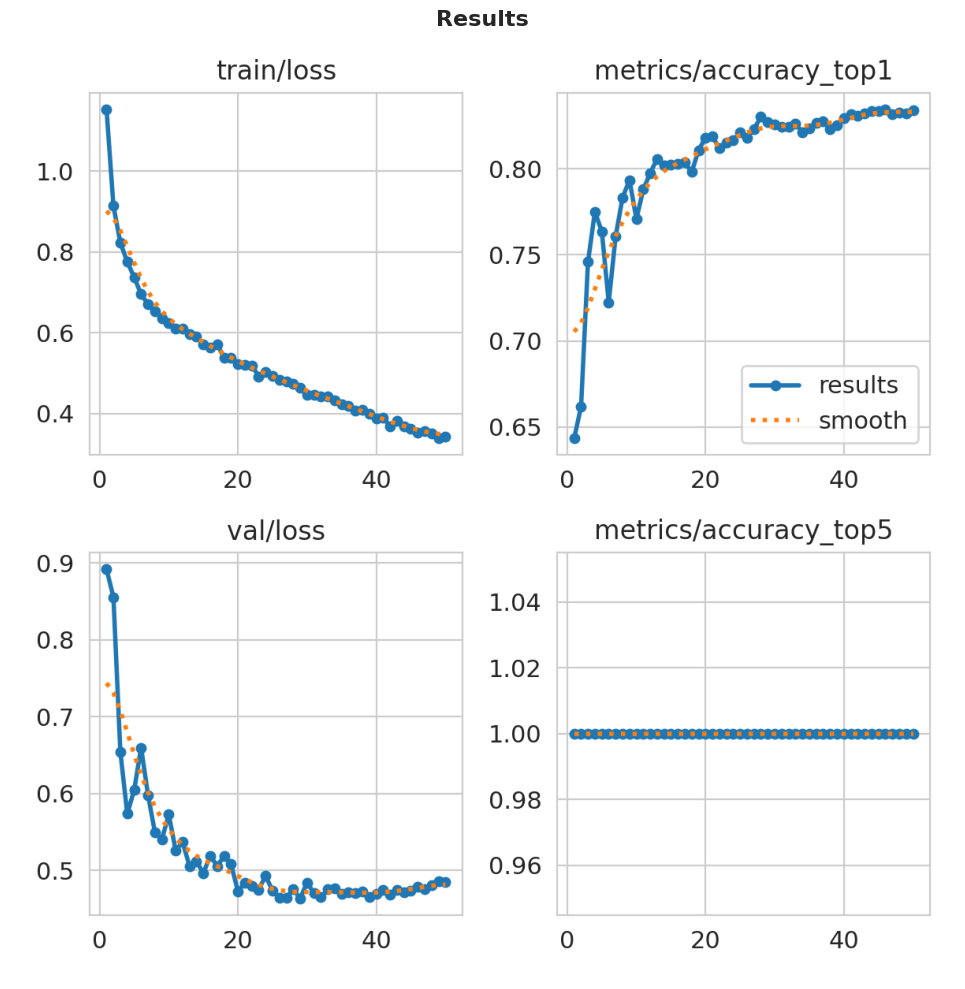

results.png


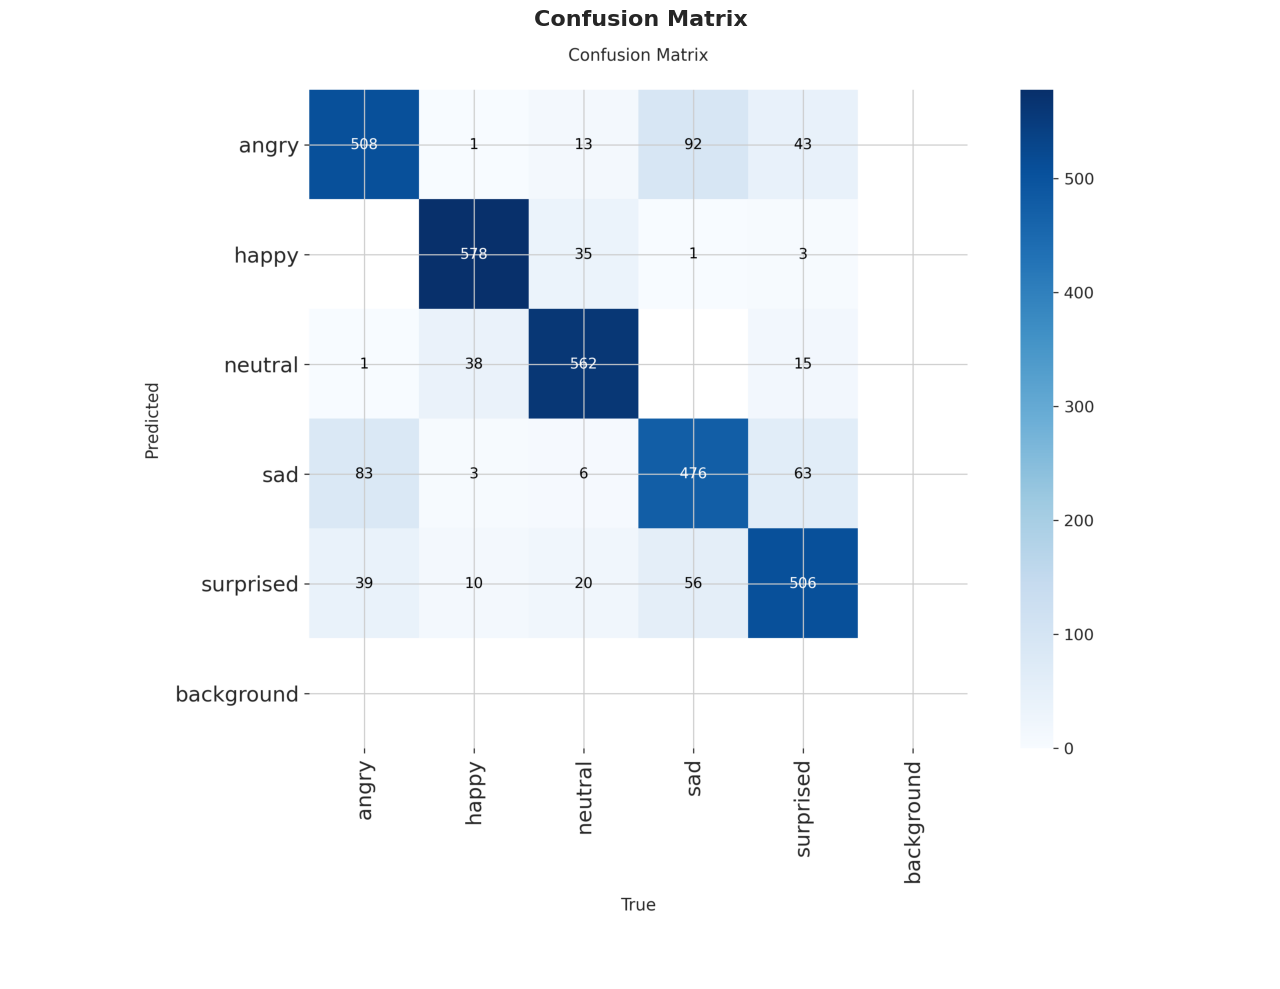

confusion_matrix.png


In [13]:
# Display training results
print("TRAINING RESULTS")

# Find and display generated plots
plot_dir = os.path.join(OUTPUT_DIR, 'fer_yolov8')

plots_to_show = ['results.png', 'confusion_matrix.png']

for plot_name in plots_to_show:
    plot_path = os.path.join(plot_dir, plot_name)
    if os.path.exists(plot_path):
        img = Image.open(plot_path)
        plt.figure(figsize=(14, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title(plot_name.replace('.png', '').replace('_', ' ').title(), fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        print(f"{plot_name}")
    else:
        print(f"{plot_name} not found")

## 13. Validate Model on Test Set

In [14]:
print("EVALUATING ON TEST SET")

# Load best model
best_model_path = os.path.join(OUTPUT_DIR, 'fer_yolov8', 'weights', 'best.pt')
best_model = YOLO(best_model_path)

# Validate on test set
print("Running validation on test set...")
metrics = best_model.val(
    data=yolo_dataset_dir,
    split='test',
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE
)

print("TEST SET METRICS")
print(f"Top-1 Accuracy: {metrics.top1:.4f} ({metrics.top1*100:.2f}%)")
print(f"Top-5 Accuracy: {metrics.top5:.4f} ({metrics.top5*100:.2f}%)")

EVALUATING ON TEST SET
Running validation on test set...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,441,285 parameters, 0 gradients, 3.3 GFLOPs
train: /content/output/yolo_fer_dataset/train... found 11213 images in 5 classes ✅ 
val: /content/output/yolo_fer_dataset/val... found 3152 images in 5 classes ✅ 
test: /content/output/yolo_fer_dataset/test... found 1656 images in 5 classes ✅ 
test: Fast image access ✅ (ping: 0.0±0.0 ms, read: 210.5±90.0 MB/s, size: 6.9 KB)
test: Scanning /content/output/yolo_fer_dataset/test... 1656 images, 0 corrupt: 100% ━━━━━━━━━━━━ 1656/1656 5.1Kit/s 0.3s
test: New cache created: /content/output/yolo_fer_dataset/test.cache
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 104/104 61.3it/s 1.7s
                   all       0.86          1
Speed: 0.0ms preprocess, 0.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/runs/classify/val


### 14. Detailed Per-Class Evaluation

In [15]:
# Get detailed per-class predictions
print("Running detailed evaluation...")

y_true = []
y_pred = []

for class_name in CLASS_NAMES:
    class_dir = os.path.join(yolo_test_dir, class_name)
    if not os.path.exists(class_dir):
        continue

    class_idx = CLASS_NAMES.index(class_name)
    img_files = [f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    print(f"Processing {class_name}: {len(img_files)} images...")

    for img_file in img_files:
        img_path = os.path.join(class_dir, img_file)

        # Predict
        results = best_model(img_path, verbose=False)

        if len(results) > 0:
            probs = results[0].probs.data.cpu().numpy()
            pred_idx = probs.argmax()

            y_true.append(class_idx)
            y_pred.append(pred_idx)

# Convert to numpy
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
print("CLASSIFICATION REPORT")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

# Overall accuracy
accuracy = np.mean(y_pred == y_true)
print(f"OVERALL TEST ACCURACY: {accuracy*100:.2f}%")

Running detailed evaluation...
Processing angry: 332 images...
Processing happy: 330 images...
Processing neutral: 338 images...
Processing sad: 326 images...
Processing surprised: 330 images...
CLASSIFICATION REPORT
              precision    recall  f1-score   support

       angry     0.8344    0.8193    0.8267       332
       happy     0.9290    0.9121    0.9205       330
     neutral     0.9045    0.8964    0.9004       338
         sad     0.7729    0.8558    0.8122       326
   surprised     0.8677    0.8152    0.8406       330

    accuracy                         0.8599      1656
   macro avg     0.8617    0.8598    0.8601      1656
weighted avg     0.8621    0.8599    0.8604      1656

OVERALL TEST ACCURACY: 85.99%


In [21]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
print("Running detailed evaluation...")

y_true = []
y_pred = []

for class_name in CLASS_NAMES:
    class_dir = os.path.join(yolo_test_dir, class_name)
    if not os.path.exists(class_dir):
        continue

    class_idx = CLASS_NAMES.index(class_name)
    img_files = [f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    print(f"Processing {class_name}: {len(img_files)} images...")

    for img_file in img_files:
        img_path = os.path.join(class_dir, img_file)

        # Predict
        results = best_model(img_path, verbose=False)

        if len(results) > 0:
            probs = results[0].probs.data.cpu().numpy()
            pred_idx = probs.argmax()

            y_true.append(class_idx)
            y_pred.append(pred_idx)

# Convert to numpy
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Overall accuracy
accuracy = np.mean(y_pred == y_true)
print(f"\nOVERALL TEST ACCURACY: {accuracy*100:.2f}%\n")

# Classification report as dictionary
report_dict = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True, digits=4)

# Convert to pandas DataFrame for tabular display
report_df = pd.DataFrame(report_dict).transpose()

# Round values for readability
report_df = report_df.round(4)

print("CLASSIFICATION REPORT (Tabular Form):")
print(report_df)

Running detailed evaluation...
Processing angry: 332 images...
Processing happy: 330 images...
Processing neutral: 338 images...
Processing sad: 326 images...
Processing surprised: 330 images...

OVERALL TEST ACCURACY: 85.99%

CLASSIFICATION REPORT (Tabular Form):
              precision  recall  f1-score    support
angry            0.8344  0.8193    0.8267   332.0000
happy            0.9290  0.9121    0.9205   330.0000
neutral          0.9045  0.8964    0.9004   338.0000
sad              0.7729  0.8558    0.8122   326.0000
surprised        0.8677  0.8152    0.8406   330.0000
accuracy         0.8599  0.8599    0.8599     0.8599
macro avg        0.8617  0.8598    0.8601  1656.0000
weighted avg     0.8621  0.8599    0.8604  1656.0000


### 15. Confusion Matrix Visualization

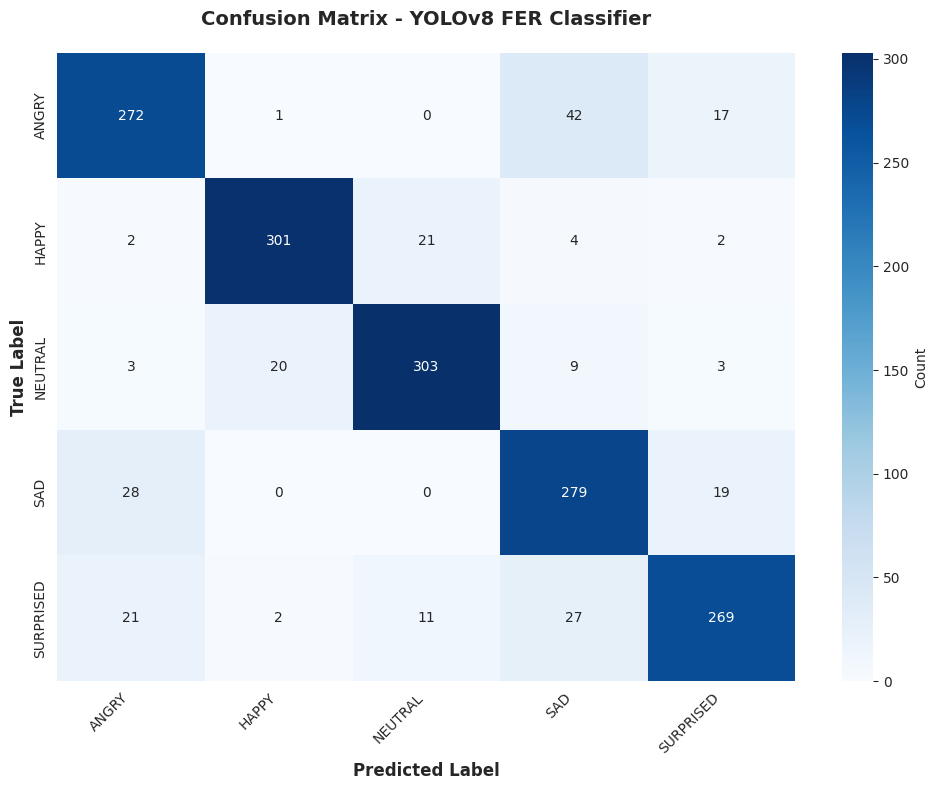

Saved: /content/output/confusion_matrix_yolov8.png


In [16]:
# Create confusion matrix visualization
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[c.upper() for c in CLASS_NAMES],
    yticklabels=[c.upper() for c in CLASS_NAMES],
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - YOLOv8 FER Classifier',
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save
cm_path = os.path.join(OUTPUT_DIR, 'confusion_matrix_yolov8.png')
plt.savefig(cm_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {cm_path}")

✓ Variables already defined from previous cells

Test directory: /content/output/yolo_fer_dataset/test
  Processing angry: 332 images...
  Processing happy: 330 images...
  Processing neutral: 338 images...
  Processing sad: 326 images...
  Processing surprised: 330 images...

✓ Collected 1656 predictions


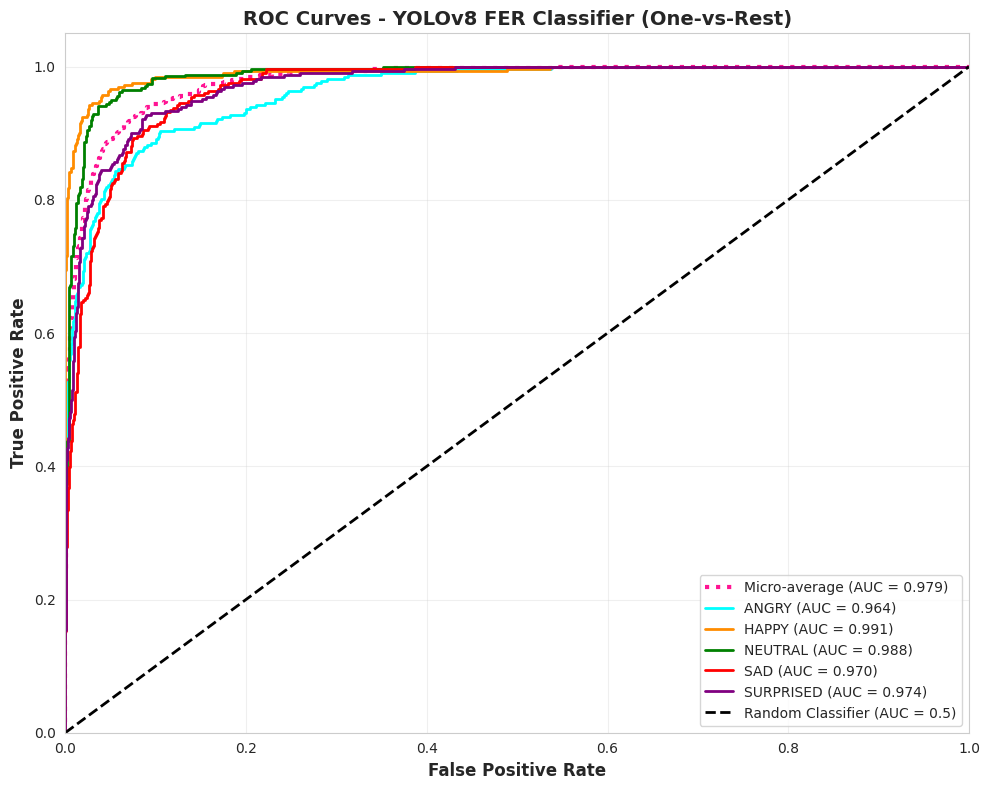


✓ Saved: /content/output/roc_curves_yolov8.png

ROC AUC Scores (1.0 = Perfect, 0.5 = Random):
  angry       : 0.9640
  happy       : 0.9910
  neutral     : 0.9880
  sad         : 0.9701
  surprised   : 0.9737
  Micro-avg   : 0.9789


In [17]:
# ROC Curves for Multi-class Classification (Standalone - Works After Training)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import os
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# ============== CONFIGURATION (if not already defined) ==============
try:
    CLASS_NAMES
    OUTPUT_DIR
    yolo_test_dir
    best_model
    print("✓ Variables already defined from previous cells")
except NameError:
    print("⚠ Defining variables (you shut down session)")
    CLASS_NAMES = ['angry', 'happy', 'neutral', 'sad', 'surprised']
    OUTPUT_DIR = '/content/output'
    IMG_SIZE = 128
    BATCH_SIZE = 16
    yolo_test_dir = os.path.join(OUTPUT_DIR, 'yolo_fer_dataset', 'test')

    # Load the trained model
    best_model_path = os.path.join(OUTPUT_DIR, 'fer_yolov8', 'weights', 'best.pt')
    if not os.path.exists(best_model_path):
        raise FileNotFoundError(f"Model not found at {best_model_path}\nMake sure training completed!")
    best_model = YOLO(best_model_path)
    print(f"✓ Loaded model from: {best_model_path}")

NUM_CLASSES = len(CLASS_NAMES)

# ============== COLLECT PROBABILITY PREDICTIONS ==============
y_probs = []
y_true_roc = []

print("\nCollecting probability predictions for ROC analysis...")
print(f"Test directory: {yolo_test_dir}")

for class_name in CLASS_NAMES:
    class_dir = os.path.join(yolo_test_dir, class_name)
    if not os.path.exists(class_dir):
        print(f"⚠ Warning: {class_dir} not found, skipping...")
        continue

    class_idx = CLASS_NAMES.index(class_name)
    img_files = [f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    print(f"  Processing {class_name}: {len(img_files)} images...")

    for img_file in img_files:
        img_path = os.path.join(class_dir, img_file)
        results = best_model(img_path, verbose=False)

        if len(results) > 0:
            probs = results[0].probs.data.cpu().numpy()
            y_probs.append(probs)
            y_true_roc.append(class_idx)

# Convert to numpy arrays
y_true_roc = np.array(y_true_roc)
y_probs = np.array(y_probs)

print(f"\n✓ Collected {len(y_true_roc)} predictions")

# ============== COMPUTE ROC CURVES ==============
# Binarize the labels for multi-class ROC
y_true_bin = label_binarize(y_true_roc, classes=range(NUM_CLASSES))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ============== PLOT ROC CURVES ==============
plt.figure(figsize=(10, 8))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})',
         color='deeppink', linestyle=':', linewidth=3)

# Plot ROC curve for each class
colors = cycle(['aqua', 'darkorange', 'green', 'red', 'purple'])
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{CLASS_NAMES[i].upper()} (AUC = {roc_auc[i]:.3f})')

# Plot diagonal (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - YOLOv8 FER Classifier (One-vs-Rest)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

# Save
roc_path = os.path.join(OUTPUT_DIR, 'roc_curves_yolov8.png')
plt.savefig(roc_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\n{'='*60}")
print(f"✓ Saved: {roc_path}")
print(f"{'='*60}")
print("\nROC AUC Scores (1.0 = Perfect, 0.5 = Random):")
for i in range(NUM_CLASSES):
    print(f"  {CLASS_NAMES[i]:12s}: {roc_auc[i]:.4f}")
print(f"  {'Micro-avg':12s}: {roc_auc['micro']:.4f}")
print(f"{'='*60}")

## 16. Export Model for Deployment

In [18]:
print("EXPORTING MODELS FOR DEPLOYMENT")

# 1. Copy best PyTorch model
pt_path = os.path.join(OUTPUT_DIR, 'fer_yolov8_cls_best.pt')
shutil.copy2(best_model_path, pt_path)
pt_size = os.path.getsize(pt_path) / (1024 * 1024)
print(f"PyTorch model: {pt_path}")
print(f"Size: {pt_size:.2f} MB")

# 2. Export to ONNX (for Raspberry Pi with ONNX Runtime)
print("\nExporting to ONNX...")
best_model.export(format='onnx', imgsz=IMG_SIZE, simplify=True)

# Find and copy ONNX file
onnx_src = os.path.join(OUTPUT_DIR, 'fer_yolov8', 'weights', 'best.onnx')
onnx_dst = os.path.join(OUTPUT_DIR, 'fer_yolov8_cls.onnx')

if os.path.exists(onnx_src):
    shutil.copy2(onnx_src, onnx_dst)
    onnx_size = os.path.getsize(onnx_dst) / (1024 * 1024)
    print(f"ONNX model: {onnx_dst}")
    print(f"Size: {onnx_size:.2f} MB")

# 3. Try TFLite export (optional)
print("\nExporting to TFLite...")
try:
    best_model.export(format='tflite', imgsz=IMG_SIZE)

    # Find TFLite file
    for root, dirs, files in os.walk(os.path.join(OUTPUT_DIR, 'fer_yolov8')):
        for file in files:
            if file.endswith('.tflite'):
                tflite_src = os.path.join(root, file)
                tflite_dst = os.path.join(OUTPUT_DIR, 'fer_yolov8_cls.tflite')
                shutil.copy2(tflite_src, tflite_dst)
                tflite_size = os.path.getsize(tflite_dst) / (1024 * 1024)
                print(f"TFLite model: {tflite_dst}")
                print(f"  Size: {tflite_size:.2f} MB")
                break
except Exception as e:
    print(f"TFLite export failed: {e}")
    print("  Use ONNX format for Raspberry Pi instead")

print("\n" + "=" * 60)
print("EXPORT COMPLETE")
print("=" * 60)
print("\nFiles ready for download:")
print(f"  fer_yolov8_cls_best.pt  (PyTorch)")
print(f"  fer_yolov8_cls.onnx     (ONNX - recommended for Pi)")
print(f"  confusion_matrix_yolov8.png")
print("=" * 60)

EXPORTING MODELS FOR DEPLOYMENT
PyTorch model: /content/output/fer_yolov8_cls_best.pt
Size: 2.84 MB

Exporting to ONNX...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from '/content/output/fer_yolov8/weights/best.pt' with input shape (1, 3, 128, 128) BCHW and output shape(s) (1, 5) (2.8 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<=1.19.1', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 14 packages in 178ms
Prepared 6 packages in 8.08s
Installed 6 packages in 392ms
 + colorama==0.4.6
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnx==1.19.1
 + onnxruntime-gpu==1.23.2
 + onnxslim==0.1.78

requirements: AutoUpdate success ✅ 9.3s
WARNING ⚠️ requirements: Restart runtime or rerun command for upda

## 17. Test ONNX Model Inference

In [19]:
# Create a ZIP file with all models for easy download
import zipfile

print("=" * 60)
print("CREATING DOWNLOAD PACKAGE")
print("=" * 60)

# Files to include in download package
download_files = [
    ('fer_yolov8_cls_best.pt', 'PyTorch model'),
    ('fer_yolov8_cls.onnx', 'ONNX model (for Raspberry Pi)'),
    ('confusion_matrix_yolov8.png', 'Confusion matrix'),
]

# Create ZIP file
zip_path = os.path.join(OUTPUT_DIR, 'fer_models_download.zip')

with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for filename, desc in download_files:
        filepath = os.path.join(OUTPUT_DIR, filename)
        if os.path.exists(filepath):
            zipf.write(filepath, filename)
            size_mb = os.path.getsize(filepath) / (1024 * 1024)
            print(f"  Added: {filename} ({size_mb:.2f} MB) - {desc}")
        else:
            print(f"  Not found: {filename}")

zip_size = os.path.getsize(zip_path) / (1024 * 1024)
print(f"\nZIP created: {zip_path}")
print(f"   Size: {zip_size:.2f} MB")

# List all output files
print("\n" + "=" * 60)
print("ALL OUTPUT FILES")
print("=" * 60)

for f in sorted(os.listdir(OUTPUT_DIR)):
    fpath = os.path.join(OUTPUT_DIR, f)
    if os.path.isfile(fpath):
        size = os.path.getsize(fpath) / (1024 * 1024)
        print(f"  {f} ({size:.2f} MB)")

print("\n" + "=" * 60)

# Trigger download of ZIP file
from google.colab import files
print("\nDownloading ZIP file...")
files.download(zip_path)

CREATING DOWNLOAD PACKAGE
  Added: fer_yolov8_cls_best.pt (2.84 MB) - PyTorch model
  Added: fer_yolov8_cls.onnx (5.53 MB) - ONNX model (for Raspberry Pi)
  Added: confusion_matrix_yolov8.png (0.08 MB) - Confusion matrix

ZIP created: /content/output/fer_models_download.zip
   Size: 7.62 MB

ALL OUTPUT FILES
  confusion_matrix_yolov8.png (0.08 MB)
  fer_models_download.zip (7.62 MB)
  fer_yolov8_cls.onnx (5.53 MB)
  fer_yolov8_cls.tflite (2.78 MB)
  fer_yolov8_cls_best.pt (2.84 MB)
  roc_curves_yolov8.png (0.12 MB)




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>